<a href="https://colab.research.google.com/github/Nikbert/EPI_simulations/blob/main/tutorials/07_echo_planar_imaging/notebooks/01_write_and_simulate_basic_EPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example EPI sequence
(adopted from https://github.com/imr-framework/pypulseq/blob/dev/pypulseq/seq_examples/scripts/write_epi.py with some modifications)

For the first-time use select Runtime->Run All (or hit Ctrl+F9) as thie initial setup of the environment takes about a minute. In a mean time scroll down to familiarize yourself with the sequence code.

The exercises are at the at of the notebook

# Initial package set-up
This is a necessary step for the Colab environment, and it is only slow on the first run

In [402]:
try:
  import pypulseq as mr
  import sigpy as sp
  print("pypulseq package is readily available\n")

except ImportError or ModuleNotFoundError:
  #!pip install git+https://github.com/imr-framework/pypulseq.git
  !pip install sigpy
  #!pip install git+https://github.com/FrankZijlstra/pypulseq.git@bugfixes
  !pip install -q mrzerocore git+https://github.com/imr-framework/pypulseq.git
  # Frank's utils
  !wget https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/utils/utils.py

pypulseq package is readily available



# Python imports

In [403]:
import math
import warnings
import numpy as np
import sigpy as sp
from matplotlib import pyplot as plt

import pypulseq as mr

# Frank's utils
from utils import animate, simulate_2d, reconstruct

# Set high-level sequence parameters
Use the code block below to set high-level parameters such as FOV, spatial resolution, etc...

In [404]:
# Define FOV, resolution and other parameters
fov = 220e-3
Nx = 64 #60
Ny = 64 #60
slice_thickness = 4e-3  # Slice thickness
n_slices = 1
ro_duration=1200e-6 # duration of the ADC / readout event, defailt: 1200us, 240us still works
rf_duration=2.5e-3

# Set system limits
system = mr.Opts(
    max_grad=32,
    grad_unit="mT/m",
    max_slew=130,
    slew_unit="T/m/s",
    rf_ringdown_time=20e-6,
    rf_dead_time=100e-6,
    adc_dead_time=10e-6,
)

# More advansed options and switches. you may chose to disable some of these options to save time in the exercises
plot: bool = True
animate_seq: bool = True
simulate: bool = True
write_seq: bool = True
seq_filename: str = "epi_pypulseq.seq"

# Create Pulseq objects
Create all kinds of objects that we will need in the sequence, such as the slice selective RF pulse, slice selection and refocusing gradients, etc...

In [405]:
# Create 90 degree slice selection pulse and gradient
rf, gz, gz_reph = mr.make_sinc_pulse(
    flip_angle=np.pi / 2,
    system=system,
    duration=rf_duration,
    slice_thickness=slice_thickness,
    apodization=0.5,
    time_bw_product=4,
    return_gz=True,
)

# Define other gradients and ADC events
delta_k = 1 / fov
k_width = Nx * delta_k
print('delta_k',delta_k)
print('k_width',k_width)
dwell_time = ro_duration / Nx
flat_time = np.ceil(ro_duration / system.grad_raster_time) * system.grad_raster_time  # round-up to the gradient raster
gx = mr.make_trapezoid(
    channel="x",
    system=system,
    amplitude=k_width / ro_duration,
    flat_time=flat_time,
)



gx_even = mr.make_trapezoid(
    channel="x",
    system=system,
    #amplitude = (k_width) / ro_duration + 0.05,
    #amplitude = (k_width + delta_k/2) / ro_duration,
    #amplitude = (k_width + 0.05) / ro_duration,
    amplitude = (k_width) / ro_duration,
    flat_time=flat_time,
)



gx_odd = mr.make_trapezoid(
    channel="x",
    system=system,
    #amplitude = (k_width) / ro_duration - 0.127,
    amplitude = -(k_width) / ro_duration,
    flat_time=flat_time,
)

#amplitude = (k_width) / ro_duration - 0.127,
amplitude2 = (k_width - delta_k/2) / ro_duration,

#print('amplitude',amplitude)
print('amplitude2',amplitude2)

adc = mr.make_adc(
    num_samples=Nx,
    duration=ro_duration,
    delay=gx.rise_time + flat_time / 2 - (dwell_time*Nx) / 2,
    system=system,
)

# Pre-phasing gradients (in the shortest possible time or filling the available time)
gx_pre = mr.make_trapezoid(
    channel="x", system=system, area=-gx.area / 2, duration=mr.calc_duration(gz_reph),
)
gy_pre = mr.make_trapezoid(
    channel="y", system=system, area=(Ny / 2 - 1) * delta_k, duration=mr.calc_duration(gz_reph),
)

# align gradients (calculate their delays)
gx_pre, gy_pre, gz_reph=mr.align(right=[gx_pre],left=[gy_pre, gz_reph])

# Phase blip in the shortest possible time (assuming a triangle is possible)
dur = np.ceil(2 * np.sqrt(delta_k / system.max_slew) / system.grad_raster_time) * system.grad_raster_time
gy = mr.make_trapezoid(channel="y", system=system, area=-delta_k, duration=dur)

print('achieved echo spacing is {}us'.format(round(1e6*(mr.calc_duration(gx)+mr.calc_duration(gy)))))

delta_k 4.545454545454546
k_width 290.90909090909093
amplitude2 (240530.3030303031,)
achieved echo spacing is 1360us


# Construct the sequence
Contruct the sequence object and fill it up block-by-block

In [415]:
seq2 = mr.Sequence(system)  # Create a new sequence object
Ny_2 = int(Ny/2)
measured_offset_c_even = np.load('diff_center_kx_c_even.npy')
measured_offset_c_odd = np.load('diff_center_kx_c_odd.npy')

# populate the sequence object with event blocks
for s in range(n_slices):
  rf.freq_offset = gz.amplitude * slice_thickness * (s - (n_slices - 1) / 2)
  seq2.add_block(rf, gz)
  seq2.add_block(gx_pre, gy_pre, gz_reph)
  gx_curr=gx
  gx_currr=mr.scale_grad(gx,-1)
  gx_curr2=gx2
  gx_curr2r=mr.scale_grad(gx2,-1)
  gx_curr3=gx3
  gx_curr3r=mr.scale_grad(gx3,-1)

  measured_offset = 0 #.005
  gx_even = mr.make_trapezoid(channel="x", system=system, amplitude = (k_width + measured_offset) / ro_duration, flat_time=flat_time)

  gx_odd = mr.make_trapezoid(channel="x", system=system, amplitude = -(k_width - measured_offset) / ro_duration, flat_time=flat_time)

  #gx_even = gx
  #gx_odd = gx_currr

  for i in range(Ny_2):
    print('measured_offset_c_even[i,1]',measured_offset_c_even[1,i])
    #print('measured_offset_c_odd[i,1]',measured_offset_c_odd[i,1])
    gx_even = mr.make_trapezoid(channel="x", system=system,
      amplitude = (k_width + measured_offset_c_even[1,i]*2) / ro_duration,
      flat_time=flat_time)
    gx_odd = mr.make_trapezoid(channel="x", system=system,
      amplitude = -(k_width - measured_offset_c_odd[1,i]*2) / ro_duration,
      flat_time=flat_time)
    #QP phase correction seems to be off

    seq2.add_block(gx_even, adc)  # Read one line of k-space out
    seq2.add_block(gy)  # Phase blip
    seq2.add_block(gx_odd, adc)
    if i!=Ny_2-1:
      seq2.add_block(gy)  # Phase blip
      #gx_curr = mr.scale_grad(gx_curr,-1)  # Reverse polarity of read gradient


#  #Otest
#  #for i in range(Ny_2-2):
#  #  seq2.add_block(gx_curr, adc)  # Read one line of k-space out
#  #  if i!=Ny-1:
#  #    seq2.add_block(gy)  # Phase blip
#  #    gx_curr = mr.scale_grad(gx_curr,-1)  # Reverse polarity of read gradient
#
#  for i in range(1):
#    #seq.add_block(gx_curr2)  # Change first of k-space out
#    seq2.add_block(gx_curr2, adc)  # Read one line of k-space out
#    seq2.add_block(gy)  # Phase blip
#    seq2.add_block(gx_currr,adc)
#    seq2.add_block(gy)  # Phase blip
#    seq2.add_block(gx_curr3,adc)
#    seq2.add_block(gy)  # Phase blip
#    seq2.add_block(gx_curr2r, adc)  # Read one line of k-space out
#    seq2.add_block(gy)  # Phase blip
#    seq2.add_block(gx_curr, adc)  # Read one line of k-space out
#    seq2.add_block(gy)  # Phase blip
#    seq2.add_block(gx_curr3r,adc)
#    seq2.add_block(gy)  # Phase blip
#    seq2.add_block(gx_curr, adc)  # Read one line of k-space out
#    seq2.add_block(gy)  # Phase blip
#    seq2.add_block(gx_curr2r, adc)  # Read one line of k-space out
#    seq2.add_block(gy)  # Phase blip
#    seq2.add_block(gx_curr2, adc)  # Read one line of k-space out
#    seq2.add_block(gy)  # Phase blip
#    seq2.add_block(gx_currr,adc)
#    seq2.add_block(gy)  # Phase blip
#
#  for i in range(Ny-10):
#    seq2.add_block(gx_curr, adc)  # Read one line of k-space out
#    if i!=Ny-1:
#      seq2.add_block(gy)  # Phase blip
#      gx_curr = mr.scale_grad(gx_curr,-1)  # Reverse polarity of read gradient

  #for i in range(1):
  #  #seq.add_block(gx_curr2)  # Change first of k-space out
  #  seq2.add_block(gwie sich die gemessenen Daten


#x_curr2, adc)  # Read one line of k-space out
  #  seq2.add_block(gy)  # Phase blip
  #  seq2.add_block(gx_currr,adc)
  #  seq2.add_block(gy)  # Phase blip
  #  seq2.add_block(gx_curr3,adc)
  #  seq2.add_block(gy)  # Phase blip
  #  seq2.add_block(gx_curr2r, adc)  # Read one line of k-space out
  #  seq2.add_block(gy)  # Phase blip
  #  seq2.add_block(gx_curr, adc)  # Read one line of k-space out
  #  seq2.add_block(gy)  # Phase blip
  #  seq2.add_block(gx_curr3r,adc)
  #  seq2.add_block(gy)  # Phase blip

seq = mr.Sequence(system)  # Create a new sequence object
Ny_2 = int(Ny/2)

# populate the sequence object with event blocks
for s in range(n_slices):
  rf.freq_offset = gz.amplitude * slice_thickness * (s - (n_slices - 1) / 2)
  seq.add_block(rf, gz)
  seq.add_block(gx_pre, gy_pre, gz_reph)
  gx_curr=gx

  for i in range(Ny):
    seq.add_block(gx_curr, adc)  # Read one line of k-space out
    if i!=Ny-1:
      seq.add_block(gy)  # Phase blip
      gx_curr = mr.scale_grad(gx_curr,-1)  # Reverse polarity of read gradient


measured_offset_c_even[i,1] -0.01933723202491172
measured_offset_c_even[i,1] 0.017125772697525812
measured_offset_c_even[i,1] 0.0011791221301300711
measured_offset_c_even[i,1] 0.026893977808969183
measured_offset_c_even[i,1] 0.033991704874024815
measured_offset_c_even[i,1] -0.024986745993913352
measured_offset_c_even[i,1] 0.004433141312996908
measured_offset_c_even[i,1] -5.345799419683578e-05
measured_offset_c_even[i,1] -0.01573329238602035
measured_offset_c_even[i,1] -0.012909859166768067
measured_offset_c_even[i,1] 0.009427770936676745
measured_offset_c_even[i,1] -0.01022771245754621
measured_offset_c_even[i,1] -0.01931375789121928
measured_offset_c_even[i,1] -0.017424534313581506
measured_offset_c_even[i,1] 0.019185245333739873
measured_offset_c_even[i,1] 0.0017028215638766817
measured_offset_c_even[i,1] -0.010615181762467
measured_offset_c_even[i,1] -0.0141652280013249
measured_offset_c_even[i,1] -0.004081803582272149
measured_offset_c_even[i,1] -0.002579246482866414
measured_offse

# Timing check
Check whether the sequence timing is OK and the objects are consistent and compatible with each other and the target scanner

In [407]:
#(
#    ok,
#    error_report,
#) = seq.check_timing()  # Check whether the timing of the sequence is correct
#if ok:
#    print("Timing check passed successfully")
#else:
#    print("Timing check failed. Error listing follows:")
#    [print(e) for e in error_report]

# Visualize the sequence
Here we just plot the sequence timing. Due to the limitations of the Colab environment the plots are not live, no interactive zoom-in / zoom-out is possible, therefore it is necessary to use the time_range option

In [408]:
#if plot:
#  print("Plot the beginning of the sequence")
#  #seq.plot(time_range=[0, 5.22e-3], time_disp="us", show_blocks=True) # just a small initial part
#  seq.plot(time_range=[0, 8e-3], time_disp="ms")
#
#  #
#  print("Plot of the entire sequence")
#  seq.plot() # plot the entire sequence

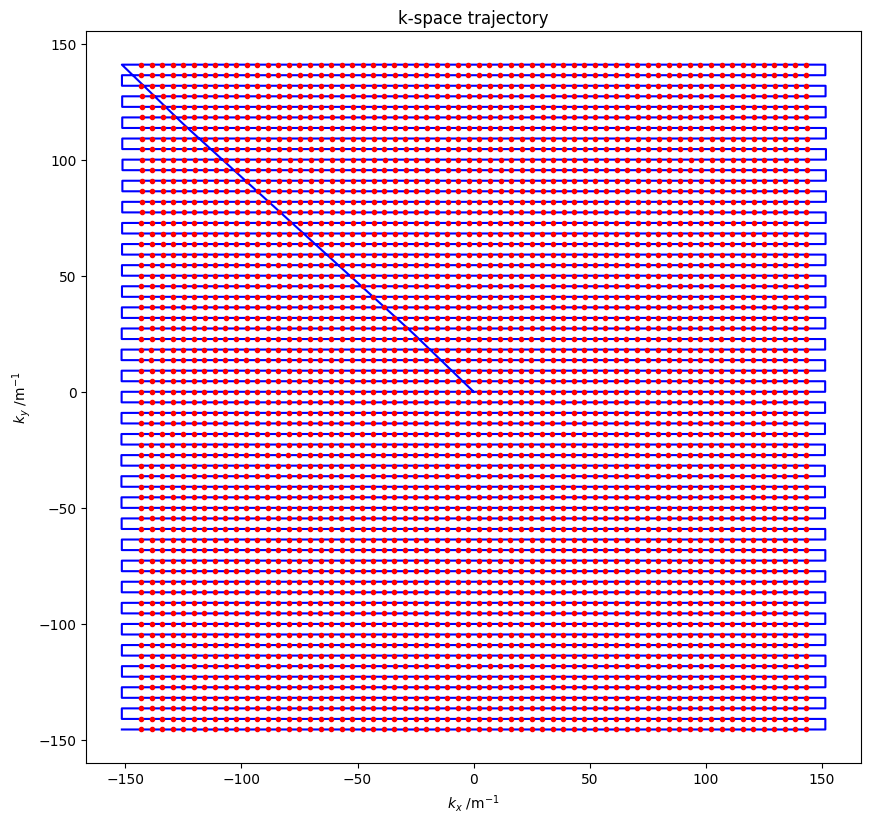

In [409]:
[k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc] = seq2.calculate_kspace()
plt.figure(figsize=(10, 10))
plt.plot(k_traj[0,],k_traj[1,], 'b-')
plt.plot(k_traj_adc[0,],k_traj_adc[1,], 'r.')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.title('k-space trajectory')
plt.xlabel(r'$k_x \mathregular{\ /m^{-1}}$')
plt.ylabel(r'$k_y \mathregular{\ /m^{-1}}$')
plt.draw()

# (Optionally) Analyze the sequence
Very optional slow step, but useful for testing during development
e.g. for the real TE, TR or for staying within slew-rate limits, etc.

In [410]:
rep = seq.test_report()
print(rep)

Number of blocks: 129
Number of events:
RF:      1
Gx:     65
Gy:     64
Gz:      2
ADC:     64
Delay:      0
Sequence duration: 0.090290 s
TE: 0.044770 s
TR: 0.090290 s
Flip angle: 90.00 deg
Unique k-space positions (aka cols, rows, etc.): 64 64 
Dimensions: 2
Spatial resolution: 3.49 mm
Spatial resolution: 3.44 mm
Repetitions/slices/contrasts: 1.0; range: [(1.0, 1.0)]
Cartesian encoding trajectory detected
Event timing check failed. Error listing follows:
 ['Event: 3 - [type: adc delay: 50.00000000000013 us dwell: 18750.0 ns]\n', 'Event: 5 - [type: adc delay: 50.00000000000013 us dwell: 18750.0 ns]\n', 'Event: 7 - [type: adc delay: 50.00000000000013 us dwell: 18750.0 ns]\n', 'Event: 9 - [type: adc delay: 50.00000000000013 us dwell: 18750.0 ns]\n', 'Event: 11 - [type: adc delay: 50.00000000000013 us dwell: 18750.0 ns]\n', 'Event: 13 - [type: adc delay: 50.00000000000013 us dwell: 18750.0 ns]\n', 'Event: 15 - [type: adc delay: 50.00000000000013 us dwell: 18750.0 ns]\n', 'Event: 17 - [t

#Write the .seq file

Set the output parameters (definitions) and write the sequence to the file.

*Note: The FOV definition is also used by the simulation/reconstruction code below*

In [411]:
# Prepare the sequence output for the scanner
seq.set_definition(key="FOV", value=[fov, fov, slice_thickness*n_slices])
seq.set_definition(key="Name", value="epi")
#
#if write_seq:
#  # Write the sequence file
#  seq.write(seq_filename)
#  from google.colab import files
#  files.download(seq_filename)  # Download locally

#Animate trajectory

In [412]:
#if animate_seq:
#  ani = animate(seq, show=False, dt=1e-3, fps=5, show_progress=True) # additional paremeter: time_range=[start, end]
#  from IPython.display import HTML
#  display(HTML(ani.to_html5_video()))

**Run MR-zero simulation**

The code below simulates the whole sequence, and shows the magnitude of the raw k-space profiles.

Calculating repetition 1 / 1 - done
Calculating repetition 1 / 1 - done


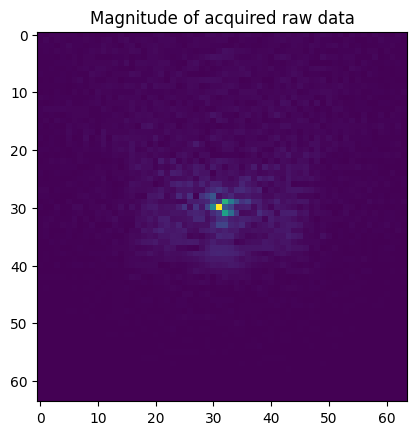

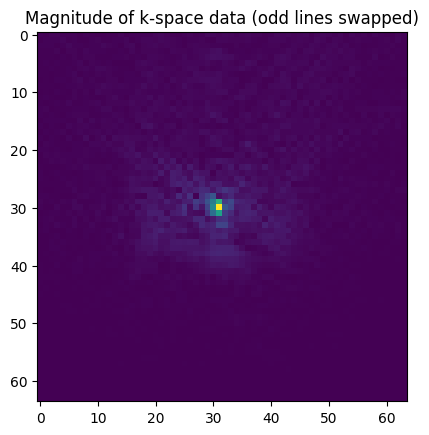

In [413]:
if simulate:
  # Simulate sequence
  kdata = simulate_2d(seq, sim_size=[Nx*2,Ny*2], noise_level=0, n_coils=1) # B0_polynomial=[...] optional parameter: B0_offset, Gx, Gy, x^2, y^2, x*y; units??? good value 200
  kdata2 = simulate_2d(seq2, sim_size=[Nx*2,Ny*2], noise_level=0, n_coils=1)

  # Display raw data profiles
  plt.figure()
  plt.imshow(abs(kdata[0].reshape(-1,adc.num_samples)))
  plt.title('Magnitude of acquired raw data'); # raw data, not k-space data (odd/even lines not reverted)

  # Display the data more correctly
  kdata_swapped=np.zeros_like(kdata)
  kdata_swapped[:,0::2,:]=kdata[:,0::2,:]
  kdata_swapped[:,1::2,:]=kdata[:,1::2,::-1]
  plt.figure()
  plt.imshow(abs(kdata_swapped[0].reshape(-1,adc.num_samples)))
  plt.title('Magnitude of k-space data (odd lines swapped)'); # raw data, not k-space data (odd/even lines not reverted)


**Reconstruction**

Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

test


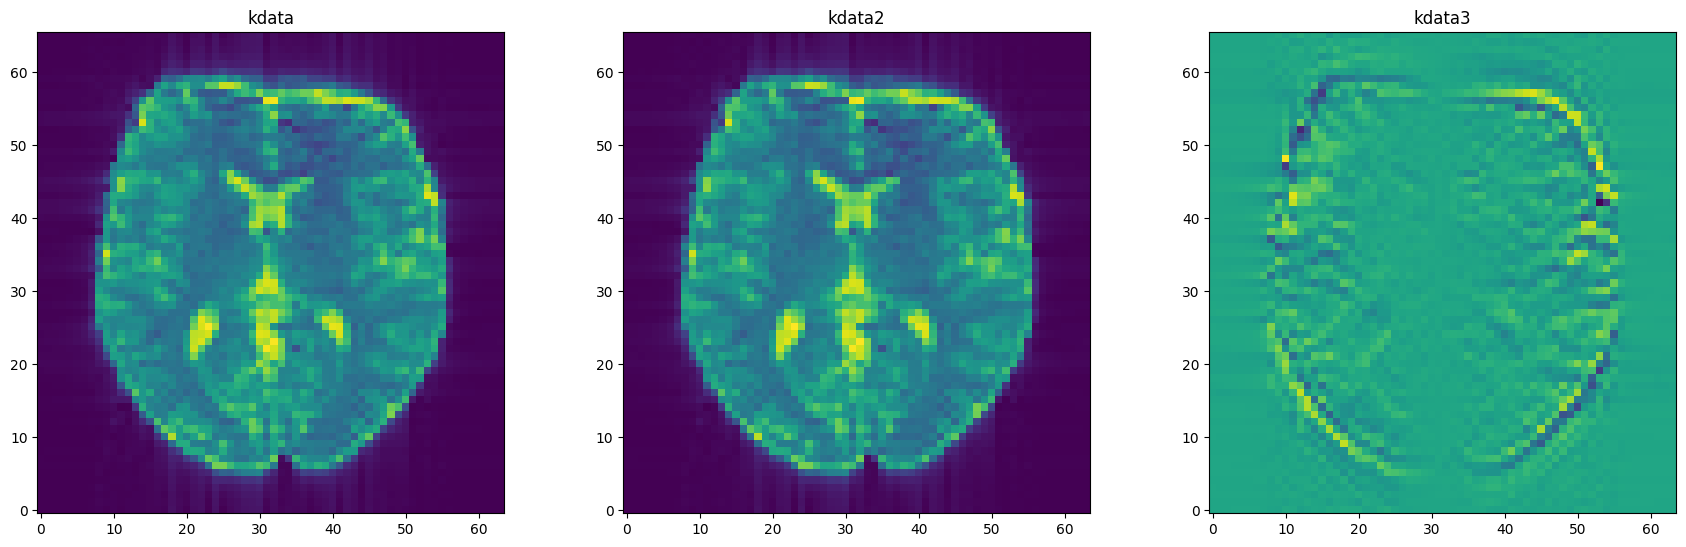

In [414]:
if simulate:
  rec = reconstruct(kdata, seq, trajectory_delay=0e-6, cartesian=False) # for the trajectory delay to work with the basic (non-ramp-sampling EPI) cartesian=False is needed
  # need to invert data dimentions because the reconstruction code uses iFFT to go from k-space to image space
  rec=rec[::-1,::-1]



  rec2 = reconstruct(kdata2, seq, trajectory_delay=0e-6, cartesian=False) # for the trajectory delay to work with the basic (non-ramp-sampling EPI) cartesian=False is needed
  # need to invert data dimentions because the reconstruction code uses iFFT to go from k-space to image space
  rec2=rec2[::-1,::-1]

  fig, ax = plt.subplots(nrows=1, ncols=3)
  ax = ax.flatten()

  ax[0].imshow(abs(rec), origin='lower')
  ax[0].set_title('kdata')

  ax[1].imshow(abs(rec2), origin='lower')
  ax[1].set_title('kdata2')
  print('test')
  ax[2].imshow(abs(rec2)-abs(rec), origin='lower')
  ax[2].set_title('kdata3')

  fig.tight_layout()
  fig.set_figheight(6)
  fig.set_figwidth(18)
  plt.show();

# Exercises (getting familiar with EPI)
* **Familiarize yourself with the sequence**: find parameters to control FOV, spatial resolution, slice number and thickness, and readout bandwidth.
* **Implement an additional option for suppressing / inverting phase encoding**: one posibility is to add a switch `pe_switch` or similar variable to the "high-level sequence parameters" section taking values of (1,0,-1) and implement necessary code alternations. Known limitation of the code: the the image reconstruction will crash without phase encoding.
* **Experiment with B0_polynomial and pe_switch**, modify echo spacing by testing various values of `ro_duration` and visualize geometric distortions. Enhance distordion appearence by inverting the PE sign. `B0_polynomial` is an optional parameter to the `simulate_2d()` call and can be specified as `B0_polynomial=[0,0,0,0,0,0]`. The later setting will also reset the default (measured) B0 field map provided with the phantom data set. Setting any of the values in the array to non-zeros will induce corresponding spatial field term, see the comment to the `simulate_2d()` call.  
* **Check yourself**
  1. What is the native Pulseq unit for the gradient strength?
  2. Can you read the current spatial resolution from the k-space plot?
  3. What is the Pulseq native unit for the RF amplitude?
  4. Why certain combinations of matrix size and readout duration are not possible?
